In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from utils import *
import experiment


In [3]:
import sys
sys.path.insert(1, '../')

import experiment
import pickle
from utils import *
from Architectures import *
import random, os
suppress_warnings()
EPOCHS = 256


def countp(model, params):
    tmp = model(**params)
    tmp.build(input_shape=(1,15,7))
    return tmp.count_params()


n_params = []

os.environ['PYTHONHASHSEED']=str(0)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.0f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])


filename = '../data/data100k_raw_combined_atlas_cut.pkl'
SUFFIX = ''


#TESTING ######
# EPOCHS = 2
# filename = '../data/data50k_raw_combined_atlas_cut_small.pkl'
# n_experiments = 2
# SUFFIX = 'latent28'
###########

In [4]:
import seaborn as sns
import os

#to get latex to work 
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']
PI = experiment.Experimenter(filename)
PI.fromSaved(suffix=SUFFIX)

Initializing Experimenter
	Loading Data from ../data/data100k_raw_combined_atlas_cut.pkl
	Data Loaded
	Creating Splits
	Splits Created
Done initalizing
Loading Experimenter from Saved Experimenter at /data/delon/experimenter/data100k_raw_combined_atlas_cut
Experimenter Loaded
Getting split
Split Stored
Loading models
{'nested_concat_70_4_64_3': 'models/data100k_raw_combined_atlas_cut_nested_concat_70_4_64_3', 'nested_concat_general_68_3_64_3': 'models/data100k_raw_combined_atlas_cut_nested_concat_general_68_3_64_3', 'particlewise_128_4_64': 'models/data100k_raw_combined_atlas_cut_particlewise_128_4_64', 'tripletwise_5_(64, 128, 256, 128, 64)_64': 'models/data100k_raw_combined_atlas_cut_tripletwise_5_(64, 128, 256, 128, 64)_64', 'pairwise_5_(64, 128, 256, 128, 64)_64': 'models/data100k_raw_combined_atlas_cut_pairwise_5_(64, 128, 256, 128, 64)_64', 'pairwise_nl_5_(64, 128, 256, 128, 64)_32_64': 'models/data100k_raw_combined_atlas_cut_pairwise_nl_5_(64, 128, 256, 128, 64)_32_64', 'pairwis

2022-09-16 11:52:06.231973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-16 11:52:06.232018: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-16 11:52:06.232066: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (top1.hep.utexas.edu): /proc/driver/nvidia/version does not exist
2022-09-16 11:52:06.232628: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
PI.models

{'nested_concat_70_4_64_3': <Architectures.NestedConcat at 0x7f0a7f372c70>,
 'nested_concat_general_68_3_64_3': <Architectures.NestedConcat_General at 0x7f0a7f39efa0>,
 'particlewise_128_4_64': <Architectures.DeepSet at 0x7f0a7f39ef40>,
 'tripletwise_5_(64, 128, 256, 128, 64)_64': <Architectures.Tripletwise at 0x7f0a7f35afd0>,
 'pairwise_5_(64, 128, 256, 128, 64)_64': <Architectures.Pairwise at 0x7f0a7f2e7c10>,
 'pairwise_nl_5_(64, 128, 256, 128, 64)_32_64': <Architectures.IteratedPiPairwise at 0x7f0a7f2b5190>,
 'pairwise_nl_iter_5_((64, 64, 116, 64, 64), (64, 64, 116, 64, 64), (64, 64, 116, 64, 64))_32_64': <Architectures.IteratedPiPairwise at 0x7f0a7f263310>,
 'naivednn_256_3_2': <Architectures.DNN_Flatten at 0x7f0a7f30c8e0>,
 'dnn_256_3_2': <Architectures.DNN_Classifier at 0x7f0a7f23eb50>}

In [18]:
model = PI.models['pairwise_5_(64, 128, 256, 128, 64)_64']

In [19]:
X_test_latent, y_test_latent = PI.get_test_dataset('pairwise')

In [20]:
yhat_test = model.predict(X_test_latent)

2022-09-16 12:09:15.237088: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-16 12:09:15.238223: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2397305000 Hz


In [31]:
X_test_ATLAS, y_test_ATLAS = gen_dataset_high_level(PI.events_test, PI.events_oup_test, PI.events_tag_test, 
                                                    mrel=False ,mtautau=True, colinear_approx=True)
X_test_ATLAS = np.array(X_test_ATLAS)

100%|██████████| 60000/60000 [00:48<00:00, 1239.77it/s]


In [32]:
from sklearn.metrics import roc_curve, auc

yhat_test_roc = np.array([true for (true,false) in yhat_test])
y_test_roc    = np.array([true for (true,false) in y_test_latent   ])


fpr, tpr, thresholds = roc_curve(y_test_roc, yhat_test_roc)

In [66]:
import bisect 

location = bisect.bisect_left(tpr, 0.7)
cutoff = thresholds[location]

quantized_yhat = np.array([true>cutoff for (true, false) in yhat_test])

In [67]:
ditau_mass = np.array([event[-1] for event in X_test_ATLAS])

In [68]:
import pandas as pd

data1 = pd.DataFrame({'Signal': ditau_mass[quantized_yhat]})
data2 = pd.DataFrame({'Background':ditau_mass[~quantized_yhat]})
data = pd.concat([data1, data2], axis=1) 


In [69]:
print(data1.median(), data2.median())

Signal    132.103058
dtype: float64 Background    158.514665
dtype: float64


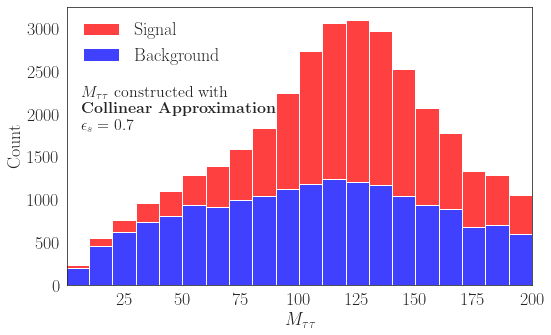

In [71]:
plt.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
plt.figure(figsize=(8,5))
mask = [False, True, False,True,False]
# cmap = np.array(sns.cubehelix_palette(start=26/10, light=.97, n_colors=5))[mask][::-1]
cmap = ['r', 'b']
mn = min(ditau_mass)
sns.set_style('white')
# sns.set_palette(sns.color_palette([ '#94d2bd', '#005f73']))

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18
plt.rcParams['figure.autolayout'] = True


ax = sns.histplot(data=data, legend=True, multiple='stack',fill=True, bins=20, binrange=(0,200), palette=cmap )
# ax.set_facecolor(np.array(sns.cubehelix_palette(start=26/10, light=.97, n_colors=5))[0])
sns.move_legend(ax, 'upper left', frameon=False)
ax.set_xlim(mn, 200)
plt.xlabel(r'$M_{\tau\tau}$')

annot_txt = r'$M_{\tau\tau}$ constructed with'
annot_txt += '\n'
annot_txt += r'\textbf{Collinear Approximation}'
annot_txt += '\n'
annot_txt += r'$\epsilon_s=0.7$'

ax.text(0.03, .55,
        s=annot_txt, 
        transform=ax.transAxes,
        horizontalalignment='left',
        verticalalignment='bottom',
       fontsize=16)


plt.savefig('figures/mtt_hist.pdf',  bbox_inches='tight')

In [ ]:
yhat_test_roc

In [8]:
train_test_split(5)

(array([3, 2, 1]), array([4, 0]))

In [10]:
train_test_split(5)

(array([3, 4, 2]), array([0, 1]))